# Implement Diffusion Model (small one)

## Import framework

In [7]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

In [8]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

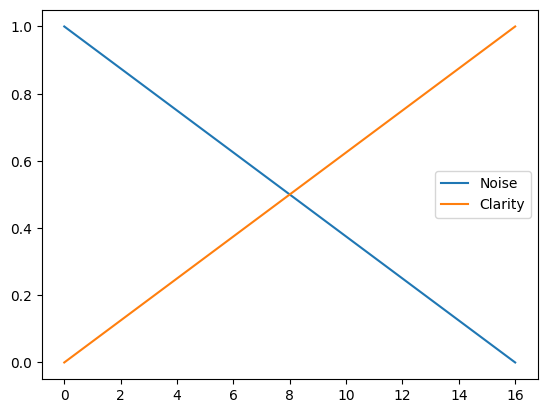

In [9]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

## Import data

In [11]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


## 1_
Look at the data. What is `all_trainset`? Diplay one element of `all_trainset`. Try to print a image 

*Hint: use .permute()*.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor([[[ 0.2078, -0.0118, -0.1765,  ..., -0.2863, -0.3176, -0.3804],
         [ 0.0980,  0.1373, -0.0196,  ..., -0.2471, -0.3961, -0.4431],
         [ 0.0980,  0.0902, -0.0980,  ..., -0.3804, -0.4667, -0.4745],
         ...,
         [ 0.3725,  0.2235,  0.2078,  ..., -0.6706, -0.5216, -0.2706],
         [ 0.2941,  0.2235,  0.2471,  ..., -0.1922, -0.0353,  0.0275],
         [ 0.2784,  0.2392,  0.2784,  ...,  0.1216,  0.1216,  0.1216]],

        [[ 0.3882,  0.0745, -0.1843,  ..., -0.2549, -0.2941, -0.3647],
         [ 0.2549,  0.2000, -0.0196,  ..., -0.2235, -0.3725, -0.4275],
         [ 0.2157,  0.1451, -0.0980,  ..., -0.3569, -0.4510, -0.4588],
         ...,
         [ 0.3098,  0.2078,  0.2549,  ..., -0.7333, -0.5843, -0.3490],
         [ 0.2078,  0.1922,  0.2627,  ..., -0.2706, -0.1059, -0.0510],
         [ 0.1608,  0.1608,  0.2235,  ...,  0.0431,  0.0510,  0.0431]],

        [[ 0.4667,  0.0667, -0.2549,  ..., -0.4431, -0.4431, -0.4510],
         [ 0.3255,  0.2078, -0.0745,  ..., -

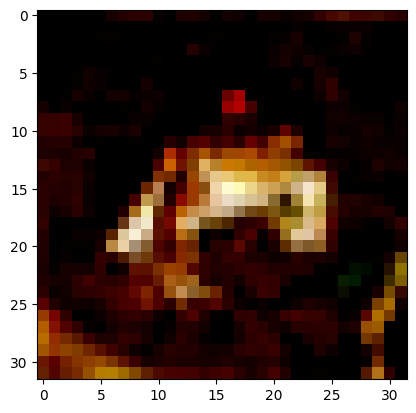

In [41]:
#print(all_trainset[0][0].shape) # 3x32x32 (3 dimensions for RGB, 32x32 pixels)
#print(len(all_trainset))
#print(all_trainset[0]) # (img, label) first image and its label
#print(all_trainset[0][0]) # img (first image)
#print(all_trainset[0][1]) # label of first image
#print(all_trainset[0][0][0]) # red
#print(all_trainset[0][0][1]) # green
#print(all_trainset[0][0][2]) # blue
#print(all_trainset[0][0][0][0]) # first row of red pixels
#print(all_trainset[0][0][0][0][0]) # first red pixel

plt.imshow(all_trainset[0][0].permute(1, 2, 0)) # permute to (32, 32, 3) for imshow


## 2_
- Create a list `idx` of idexes of elements of `all_trainset` where the label is a car.
- Then create `sub_trainset` with the class `Subset` from `torch.utils.data`.

In [48]:
idx = []
for el in range(len(all_trainset)):
    if all_trainset[el][1] == 1:
        idx.append(el)

print(len(idx))
print(idx)
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

5000
[4, 5, 32, 44, 45, 46, 60, 61, 64, 65, 75, 79, 94, 96, 97, 99, 105, 112, 119, 126, 134, 136, 137, 140, 160, 168, 176, 184, 201, 206, 212, 226, 227, 236, 238, 250, 255, 257, 261, 262, 275, 282, 301, 302, 304, 311, 312, 323, 325, 330, 354, 364, 375, 389, 393, 396, 427, 432, 454, 461, 466, 482, 486, 493, 498, 506, 524, 536, 547, 561, 565, 568, 576, 578, 590, 593, 599, 606, 617, 644, 676, 690, 699, 714, 743, 747, 753, 761, 772, 815, 823, 833, 834, 835, 840, 841, 848, 855, 873, 874, 879, 893, 917, 936, 942, 947, 962, 977, 978, 980, 991, 997, 1006, 1020, 1021, 1029, 1037, 1052, 1064, 1068, 1079, 1090, 1095, 1103, 1145, 1153, 1170, 1240, 1242, 1251, 1287, 1293, 1301, 1304, 1305, 1320, 1356, 1364, 1377, 1380, 1389, 1394, 1408, 1410, 1413, 1421, 1446, 1448, 1455, 1464, 1476, 1494, 1502, 1520, 1541, 1547, 1548, 1551, 1559, 1565, 1570, 1571, 1574, 1578, 1586, 1599, 1604, 1605, 1611, 1621, 1631, 1651, 1660, 1681, 1689, 1694, 1707, 1724, 1731, 1736, 1747, 1781, 1790, 1799, 1820, 1869, 1901, 19

In [49]:
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


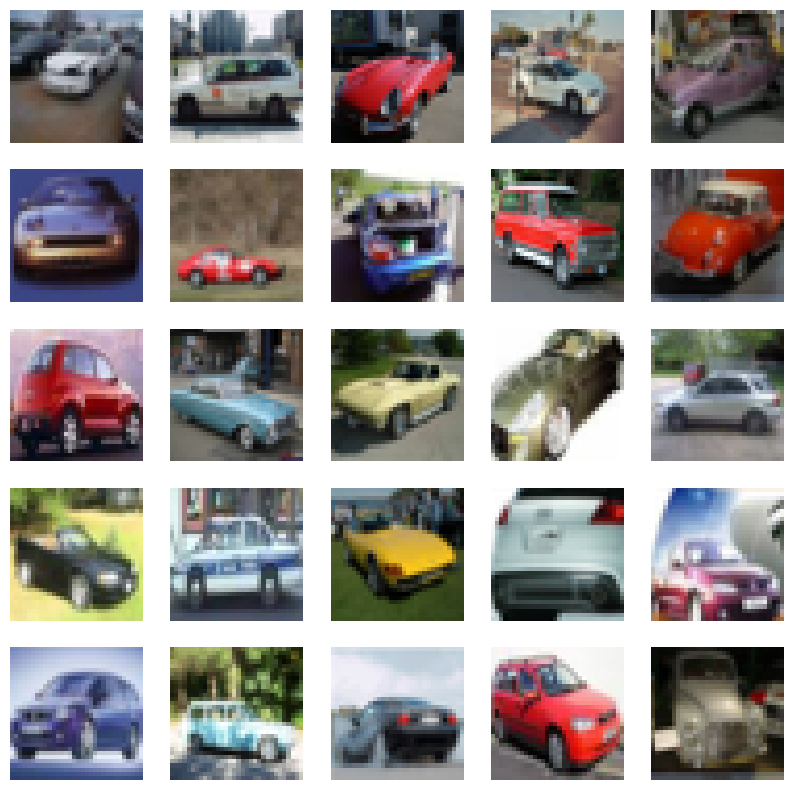

In [50]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1]) # ((img,lbl), 32, 32, 3) -> ((img,lbl), 3, 32, 32)
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

## 3_
Creation of functions.

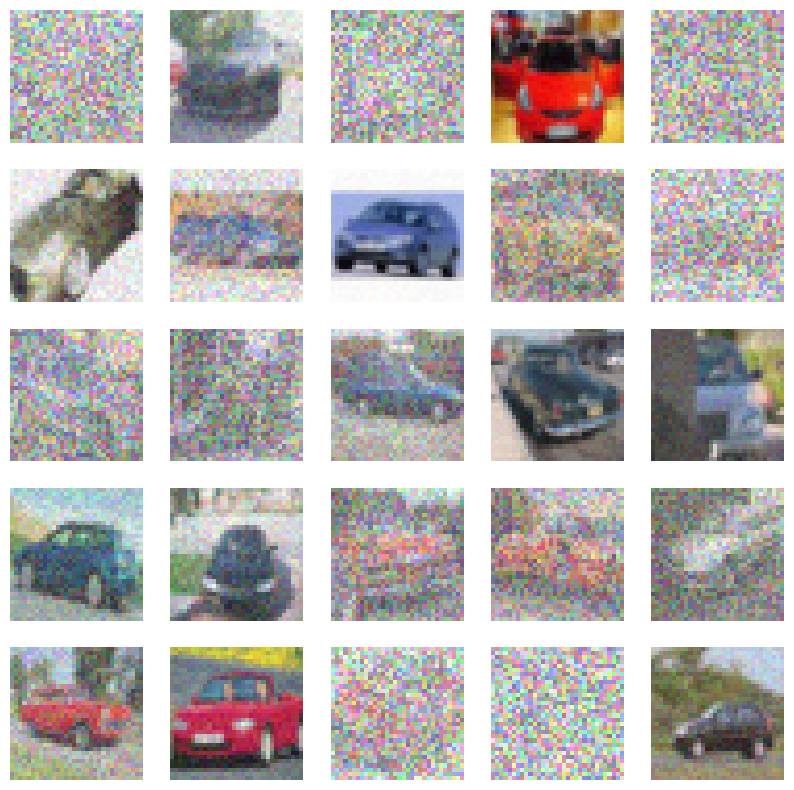

In [51]:
def forward_noise(x, t):
    """_summary_

    Args:
        x (_type_): images shape (n_images, channels, 32, 32)
        t (_type_): how 

    Returns:
        _type_: _description_
    """
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    # create random noise with the same shape as x
    noise = np.random.random(x.shape)
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)